In [1]:
import numpy as np
import pandas as pd

import time
from datetime import datetime

import gensim
import matplotlib.pyplot as plt

import en_nlp_utils
import model_evaluation_utils

In [2]:
# Define default source path
SRC_PATH = "src/"

In [3]:
# Load dataset
df_hotel = pd.read_csv(SRC_PATH + "en_hotel.csv")
df_review = pd.read_csv(SRC_PATH + "en_hotel_review.csv")

## 1) Convert data types

### a) For df_hotel dataset

In [4]:
# Convert "overall_rating_category" column as category data type
df_hotel["overall_rating_category"] = pd.Categorical(
    df_hotel["overall_rating_category"],
    categories=["Below Expectation", "Good", "Very Good", "Excellent", "Exceptional"],
    ordered=True
)

### b) For df_review dataset¶

In [5]:
# Convert "group_name" column as category data type
df_review["group_name"] = pd.Categorical(
    df_review["group_name"],
    categories=["Couple", "Family", "Family with young children", "Solo traveler", "Business traveler", "Group", "Other"],
    ordered=True
)

# Convert "review_score_category" column as category data type
df_review["review_score_category"] = pd.Categorical(
    df_review["review_score_category"],
    categories=["Below Expectation", "Good", "Very Good", "Excellent", "Exceptional"],
    ordered=True
)

# Convert "stay_date" and "review_date" columns as datetime data type
df_review["stay_date"] = pd.to_datetime(df_review["stay_date"], format="%d/%m/%Y")
df_review["review_date"] = pd.to_datetime(df_review["review_date"], format="%d/%m/%Y")

## 2) Predict Future Tourist Amount

### a) For Agoda & Booking

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


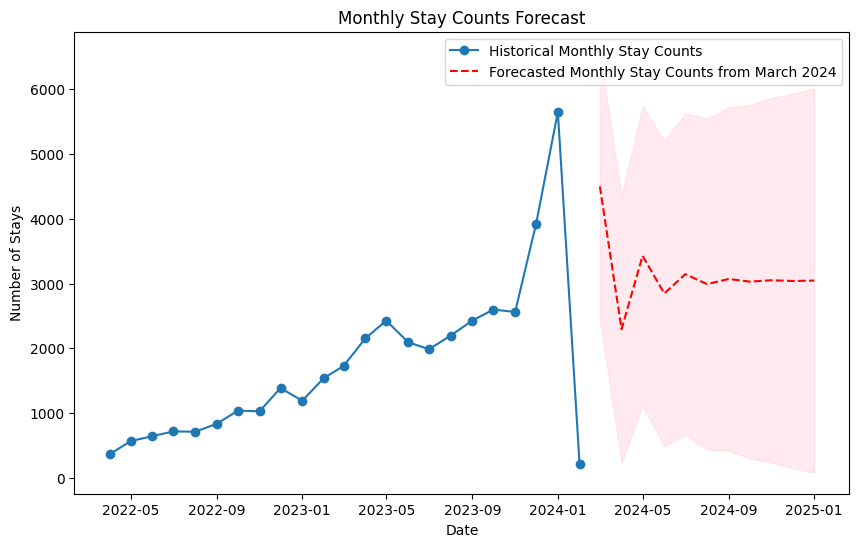

In [6]:
from statsmodels.tsa.arima.model import ARIMA

# Copy df_review into df_predict
df_predict = df_review

# Set "stay_date" as index
df_predict.set_index("stay_date", inplace=True)

# Resample the data to get monthly counts of stays
monthly_stay_counts = df_predict.resample("M").size()

# Ensure the index is a PeriodIndex for SARIMAX compatibility
monthly_stay_counts.index = monthly_stay_counts.index.to_period("M")

# Fit an ARIMA model
# The parameters (p, d, q) are chosen based on model diagnostics
model = ARIMA(monthly_stay_counts, order=(1, 1, 1))
model_fit = model.fit()

# The forecast start point should be after the last available data point
# If the last data point is May 2023, we want to forecast from March 2024 onwards
last_date = monthly_stay_counts.index[-1]
forecast_start = pd.Period("2024-03", freq="M")
steps_to_forecast = (forecast_start - last_date).n + (12 - forecast_start.month + 1)

# Forecast the necessary number of steps to reach March 2024 and beyond
forecast = model_fit.get_forecast(steps=steps_to_forecast)

# Generate the forecast index starting from March 2024
forecast_index = pd.period_range(start=forecast_start, periods=steps_to_forecast, freq="M").to_timestamp()

# Plot the historical data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_stay_counts.index.to_timestamp(), monthly_stay_counts, label="Historical Monthly Stay Counts", marker="o")
plt.plot(forecast_index, forecast.predicted_mean, label="Forecasted Monthly Stay Counts from March 2024", 
         linestyle="--", color="red")
plt.fill_between(forecast_index, 
                 forecast.conf_int().iloc[:, 0], 
                 forecast.conf_int().iloc[:, 1], 
                 color="pink", alpha=0.3)
plt.legend()
plt.title("Monthly Stay Counts Forecast")
plt.xlabel("Date")
plt.ylabel("Number of Stays")
plt.show()

### b) For Agoda

In [7]:
# Find out all hotels from Agoda / Booking
df_predict_agoda = df_predict[df_predict["source"] == "Agoda"]
df_predict_booking = df_predict[df_predict["source"] == "Booking"]

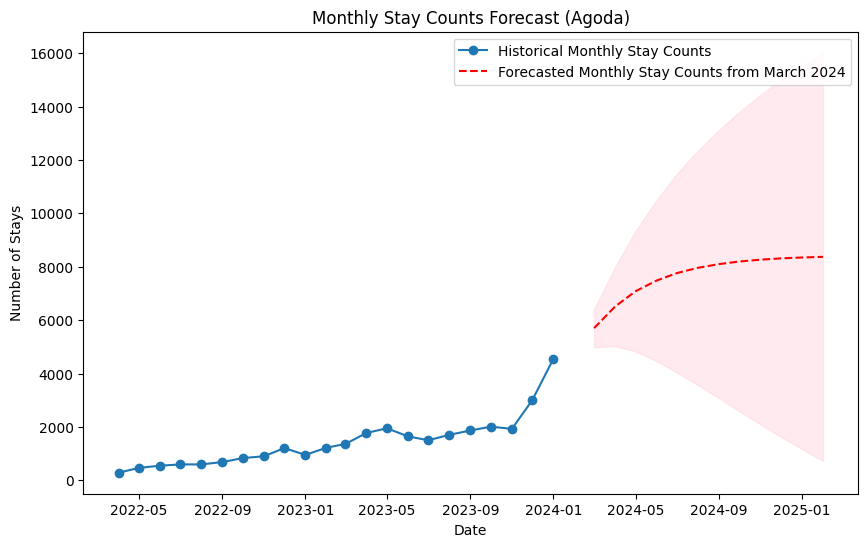

In [8]:
# Resample the data to get monthly counts of stays
monthly_stay_counts_agoda = df_predict_agoda.resample("M").size()

# Ensure the index is a PeriodIndex for SARIMAX compatibility
monthly_stay_counts_agoda.index = monthly_stay_counts_agoda.index.to_period("M")

# Fit an ARIMA model
# The parameters (p, d, q) are chosen based on model diagnostics
model_agoda = ARIMA(monthly_stay_counts_agoda, order=(1, 1, 1))
model_agoda_fit = model_agoda.fit()

# The forecast start point should be after the last available data point
# If the last data point is May 2023, we want to forecast from March 2024 onwards
last_date_agoda = monthly_stay_counts_agoda.index[-1]
forecast_start_agoda = pd.Period("2024-03", freq="M")
steps_to_forecast_agoda = (forecast_start_agoda - last_date_agoda).n + (12 - forecast_start_agoda.month + 1)

# Forecast the necessary number of steps to reach March 2024 and beyond
forecast_agoda = model_agoda_fit.get_forecast(steps=steps_to_forecast_agoda)

# Generate the forecast index starting from March 2024
forecast_agoda_index = pd.period_range(start=forecast_start_agoda, periods=steps_to_forecast_agoda, freq="M").to_timestamp()

# Plot the historical data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_stay_counts_agoda.index.to_timestamp(), monthly_stay_counts_agoda, 
         label="Historical Monthly Stay Counts", marker="o")
plt.plot(forecast_agoda_index, forecast_agoda.predicted_mean, label="Forecasted Monthly Stay Counts from March 2024", 
         linestyle="--", color="red")
plt.fill_between(forecast_agoda_index, 
                 forecast_agoda.conf_int().iloc[:, 0], 
                 forecast_agoda.conf_int().iloc[:, 1], 
                 color="pink", alpha=0.3)
plt.legend()
plt.title("Monthly Stay Counts Forecast (Agoda)")
plt.xlabel("Date")
plt.ylabel("Number of Stays")
plt.show()

### c) For Booking

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


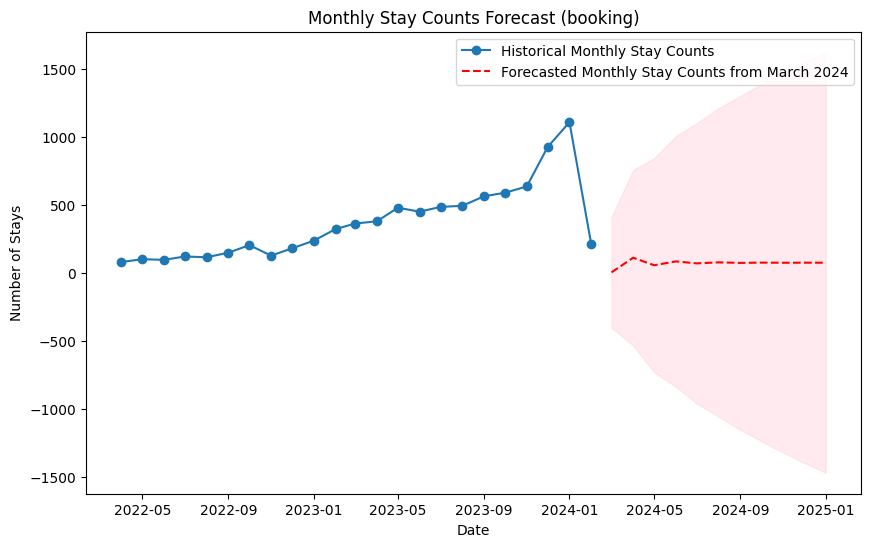

In [9]:
# Resample the data to get monthly counts of stays
monthly_stay_counts_booking = df_predict_booking.resample("M").size()

# Ensure the index is a PeriodIndex for SARIMAX compatibility
monthly_stay_counts_booking.index = monthly_stay_counts_booking.index.to_period("M")

# Fit an ARIMA model
# The parameters (p, d, q) are chosen based on model diagnostics
model_booking = ARIMA(monthly_stay_counts_booking, order=(1, 1, 1))
model_booking_fit = model_booking.fit()

# The forecast start point should be after the last available data point
# If the last data point is May 2023, we want to forecast from March 2024 onwards
last_date_booking = monthly_stay_counts_booking.index[-1]
forecast_start_booking = pd.Period("2024-03", freq="M")
steps_to_forecast_booking = (forecast_start_booking - last_date_booking).n + (12 - forecast_start_booking.month + 1)

# Forecast the necessary number of steps to reach March 2024 and beyond
forecast_booking = model_booking_fit.get_forecast(steps=steps_to_forecast_booking)

# Generate the forecast index starting from March 2024
forecast_booking_index = pd.period_range(start=forecast_start_booking, periods=steps_to_forecast_booking, freq="M").to_timestamp()

# Plot the historical data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(monthly_stay_counts_booking.index.to_timestamp(), monthly_stay_counts_booking, 
         label="Historical Monthly Stay Counts", marker="o")
plt.plot(forecast_booking_index, forecast_booking.predicted_mean, label="Forecasted Monthly Stay Counts from March 2024", 
         linestyle="--", color="red")
plt.fill_between(forecast_booking_index, 
                 forecast_booking.conf_int().iloc[:, 0], 
                 forecast_booking.conf_int().iloc[:, 1], 
                 color="pink", alpha=0.3)
plt.legend()
plt.title("Monthly Stay Counts Forecast (booking)")
plt.xlabel("Date")
plt.ylabel("Number of Stays")
plt.show()